# Fast Launch Window Grid Search

The lowest-order method is well suited for a preliminary evaluation of the launch window. Here, an Earth Mars transfer is shown as an example.
Here, all data is created and processed directly in the notebook. The github code, e.g. gridSearch114.py, includes functionality for saving to file and subsequent loading for postprocessing.

Here, the jpl ephemeris included in Pykep are used, meaning that no kernel files need to be loaded.

The grid search is performed over a wide range of launch dates and times of flight. In order to not miss any solutions the $\Delta V$ is computed for numbers of revolution in [0, 5] for each spot in the launch window. The stepSize is set to 20 days for both departure date and time of flight. Running the grid search should take about 3min.

In [1]:
import time

import numpy as np
import matplotlib as mlt
%matplotlib inline

from hodographicShaping_SI import hodographicShaping
from patchedTrajectoryUtils import ephemeris
from plottingUtilsLaunchWindow import plottingGridSearch
from plottingUtilsIndividualTrajectory import plotting

In [2]:
# optimization setup
Nmin = 0
Nmax = 5
depDateMin = 7305.
depDateMax = 10226.
tofMin = 500.
tofMax = 2001.
depBody = 'earth'
arrBody = 'mars'
stepSize= 20

In [3]:
# initialize arrays and counters
Ns = np.arange(Nmin, Nmax+1)
depDates = np.arange(depDateMin, depDateMax, stepSize)
tofs = np.arange(tofMin, tofMax, stepSize)
deltaVs = np.zeros((len(tofs), len(depDates), len(Ns)))
numberOfTrajectories = np.prod(np.shape(deltaVs))
print('Grid search using the Hodographic shaping method')
print('Computing', numberOfTrajectories, 'trajectories')
nIndex = 0
tofIndex = 0
depIndex = 0
trajectoryCounter = 1

Grid search using the Hodographic shaping method
Computing 67032 trajectories


In [4]:
# run grid search
start = time.process_time()
for i in Ns:
    for j in depDates:
        for k in tofs:
            scStateDep, __, __ = ephemeris(depBody, j, mode='jpl')
            scStateArr, __, __ = ephemeris(arrBody, j+k, mode='jpl')
            transfer = hodographicShaping(scStateDep, scStateArr,
                        departureDate=k, tof=k, N=i,
                        departureBody = depBody,
                        arrivalBody = arrBody,
                        rShape =         'CPowPow2_scaled',
                        thetaShape =     'CPowPow2_scaled',
                        zShape =         'CosR5P3CosR5P3SinR5_scaled',
                        rShapeFree =     'PSin05PCos05_scaled',
                        thetaShapeFree = 'PSin05PCos05_scaled',
                        zShapeFree =     'P4CosR5P4SinR5_scaled')
            transfer.shapingRadial()
            transfer.shapingVertical()
            transfer.shapingTransverse()
            transfer.assembleThrust()
            transfer.evaluate(evalThrust=False)

            print(str(trajectoryCounter)+'/'+str(numberOfTrajectories)+'\t'+\
                str(int(np.floor(trajectoryCounter/numberOfTrajectories*100)))+\
                '%', end='\r')
            deltaVs[tofIndex, depIndex, nIndex] = transfer.deltaV
            tofIndex += 1
            trajectoryCounter += 1
        depIndex += 1
        tofIndex = 0
    nIndex += 1
    depIndex = 0

# print elapsed time
end = time.process_time()
print('Finished computation in ', round((end - start)/60, 2), ' min')
print('Computation time per trajectory was ',
        round((end - start)*1e3/numberOfTrajectories, 2), ' ms')

# combine results in a single dictionary
results = {}
results['deltaVs'] = deltaVs
results['depDates'] = depDates
results['Ns'] = Ns
results['tofs'] = tofs

Finished computation in  2.43  min
Computation time per trajectory was  2.17  ms


The results are visualized using the plotting functions in the plottingLaunchWindow class. 
For the overall result the lowest $\Delta V$ for each N is plotted.

Plotting best imshow


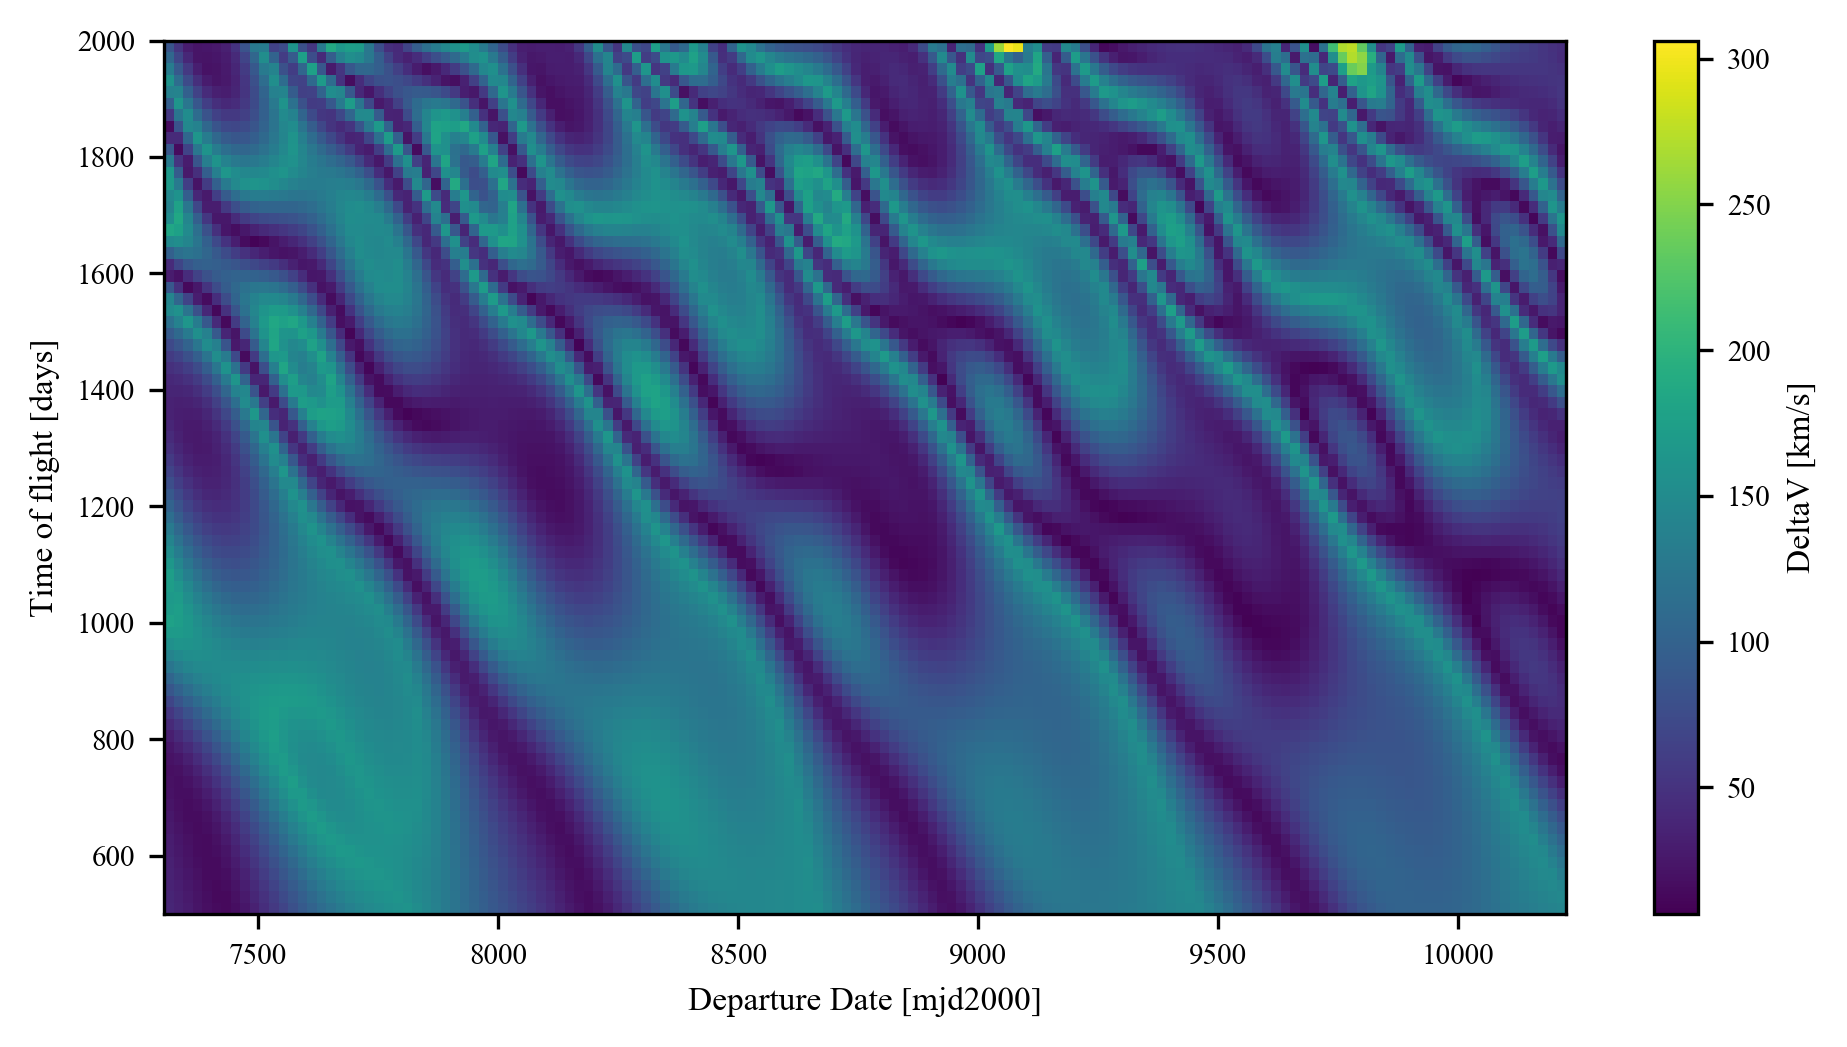

Plotting best Ns


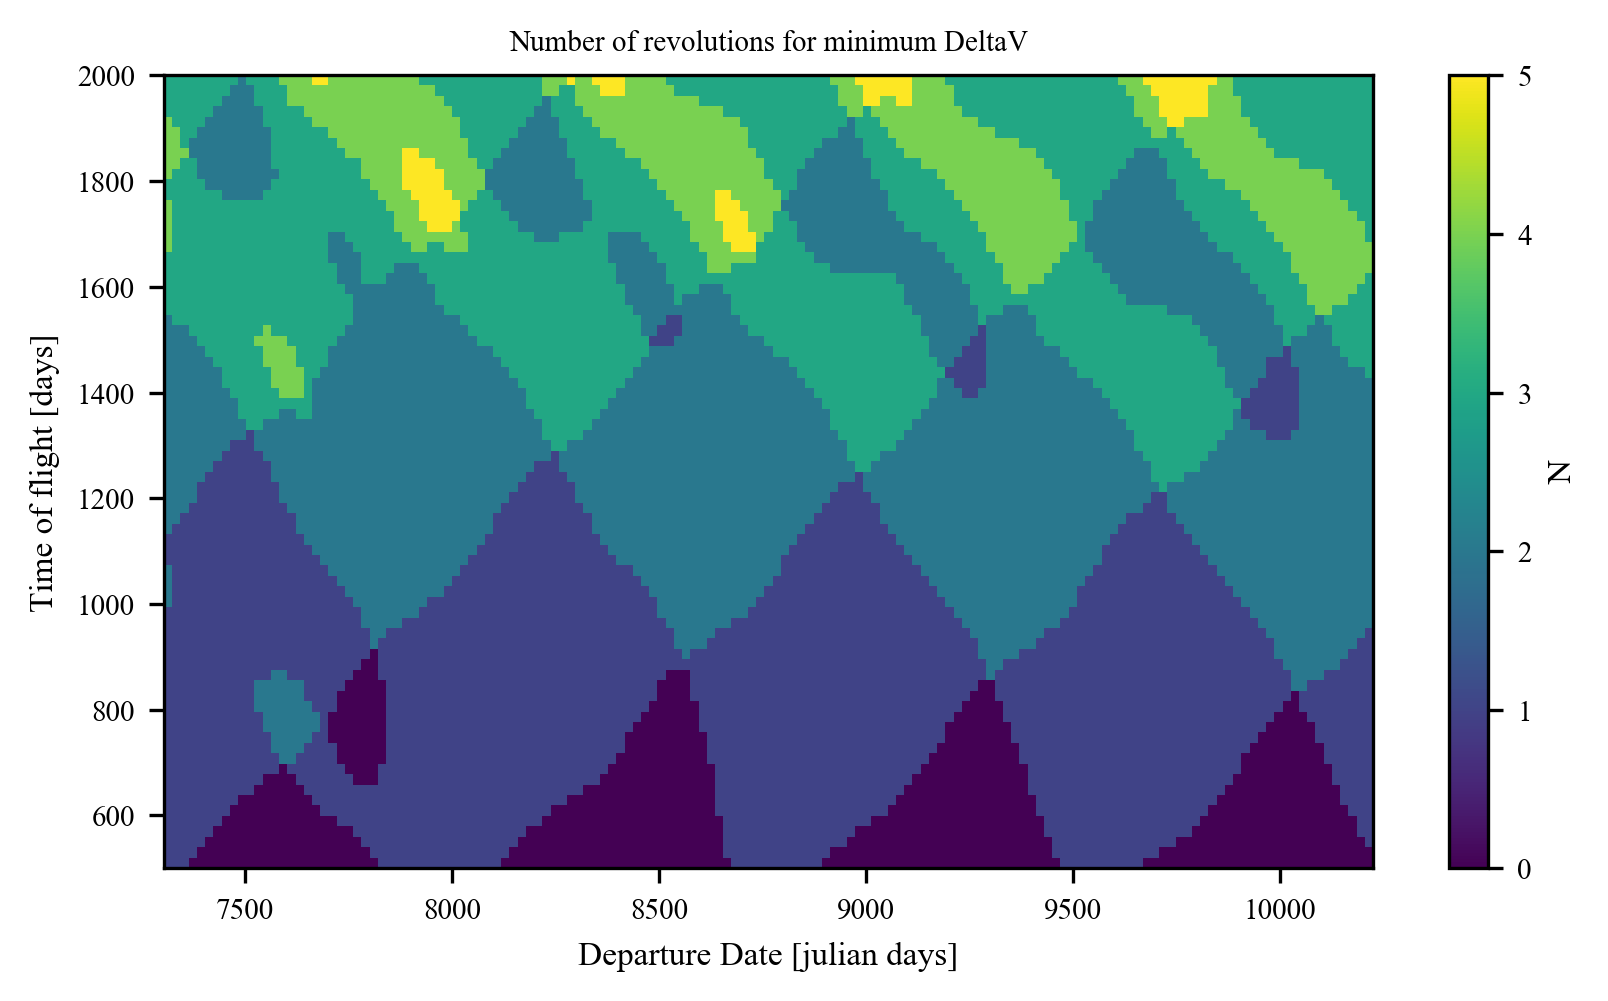

In [5]:
gridSearchVis = plottingGridSearch(results, save=False, folder=None)

# The best trajectory found for each point in the launch window
gridSearchVis.resultImshowBest()

# the corresponding number of revolutions
gridSearchVis.resultBestN()

The individual results for each N are shown here.

Plotting contour (imshow)


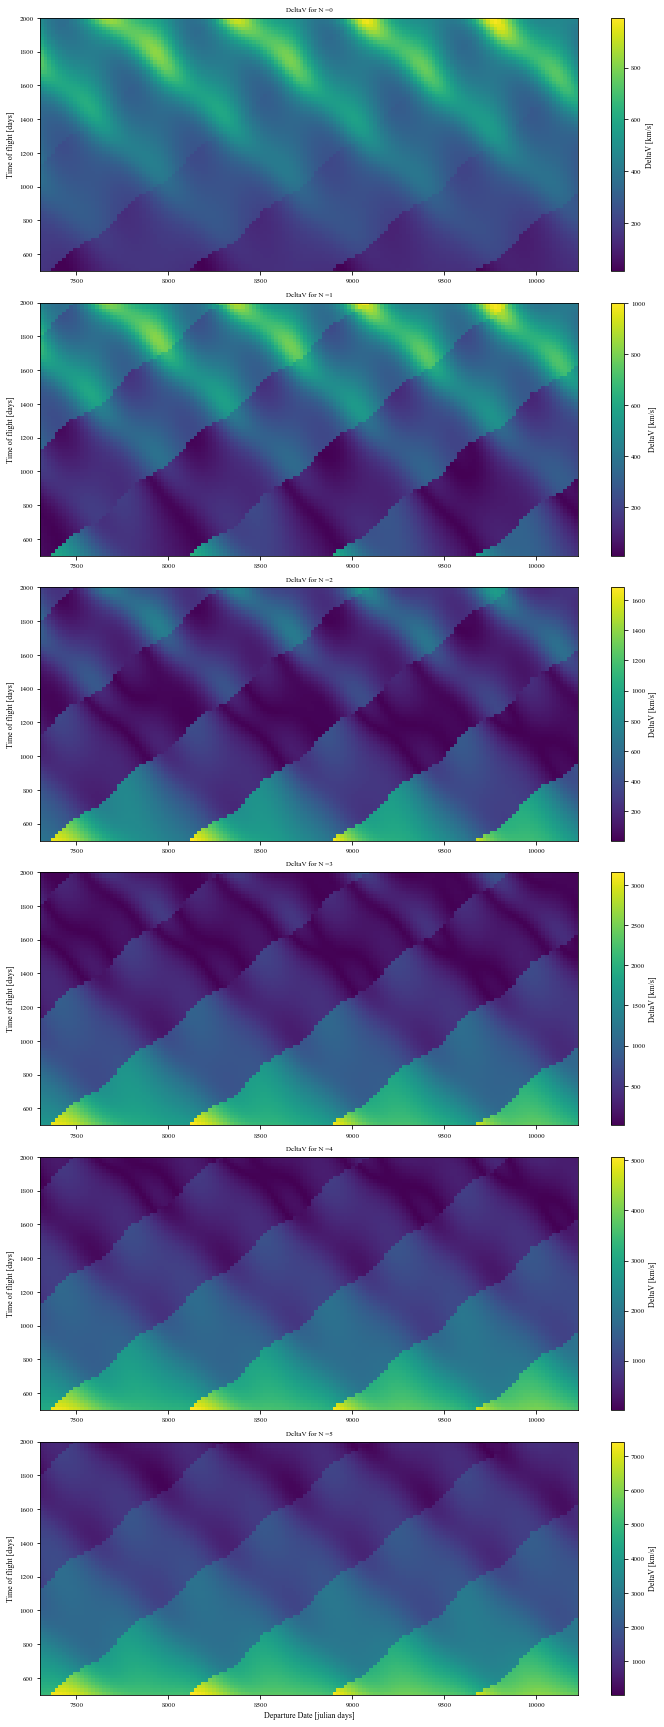

In [6]:
gridSearchVis.resultContoursImshow()

## Retrieving the best trajectory

The trajectory with minimal $\Delta V$ can be retrieved and analysed separately.


Analyse the best trajectory
###############################################################
Hodographic Shaping Problem: earth to mars

Settings
Departure state:  [ 1.52e+11 -1.72e+00  9.36e+06  1.83e+02  2.93e+04  2.84e-01]
Arrival state:	  [2.22e+11 9.50e-01 6.15e+08 2.21e+03 2.47e+04 7.99e+02]
Departure date:	 2027-Jun-13 00:00:00
Departure date:	 10025 mjd2000
Arrival date:	 2030-May-08 00:00:00
Time of Flight:	 1060  days
Revolutions:	 2
Transfer angle:  152.99  deg
Radial velocity:	 CPowPow2_scaled
Traverse velocity:	 CPowPow2_scaled
Axial velocity:		 CosR5P3CosR5P3SinR5_scaled

Free part of shape (input)
Radial velocity free:	PSin05PCos05_scaled
Traverse velocity free:	PSin05PCos05_scaled
Axial velocity free:	P4CosR5P4SinR5_scaled
Radial coefficients free:	 [0 0]
Transverse coefficients free:	 [0 0]
Vertical coefficients free:	 [0 0]

Velocity functions
Radial coefficients:		 [ 183.21 -587.52 2618.38]
Transverse coefficients:	 [29326.3   1542.67 -6184.24]
Vertical coefficients:

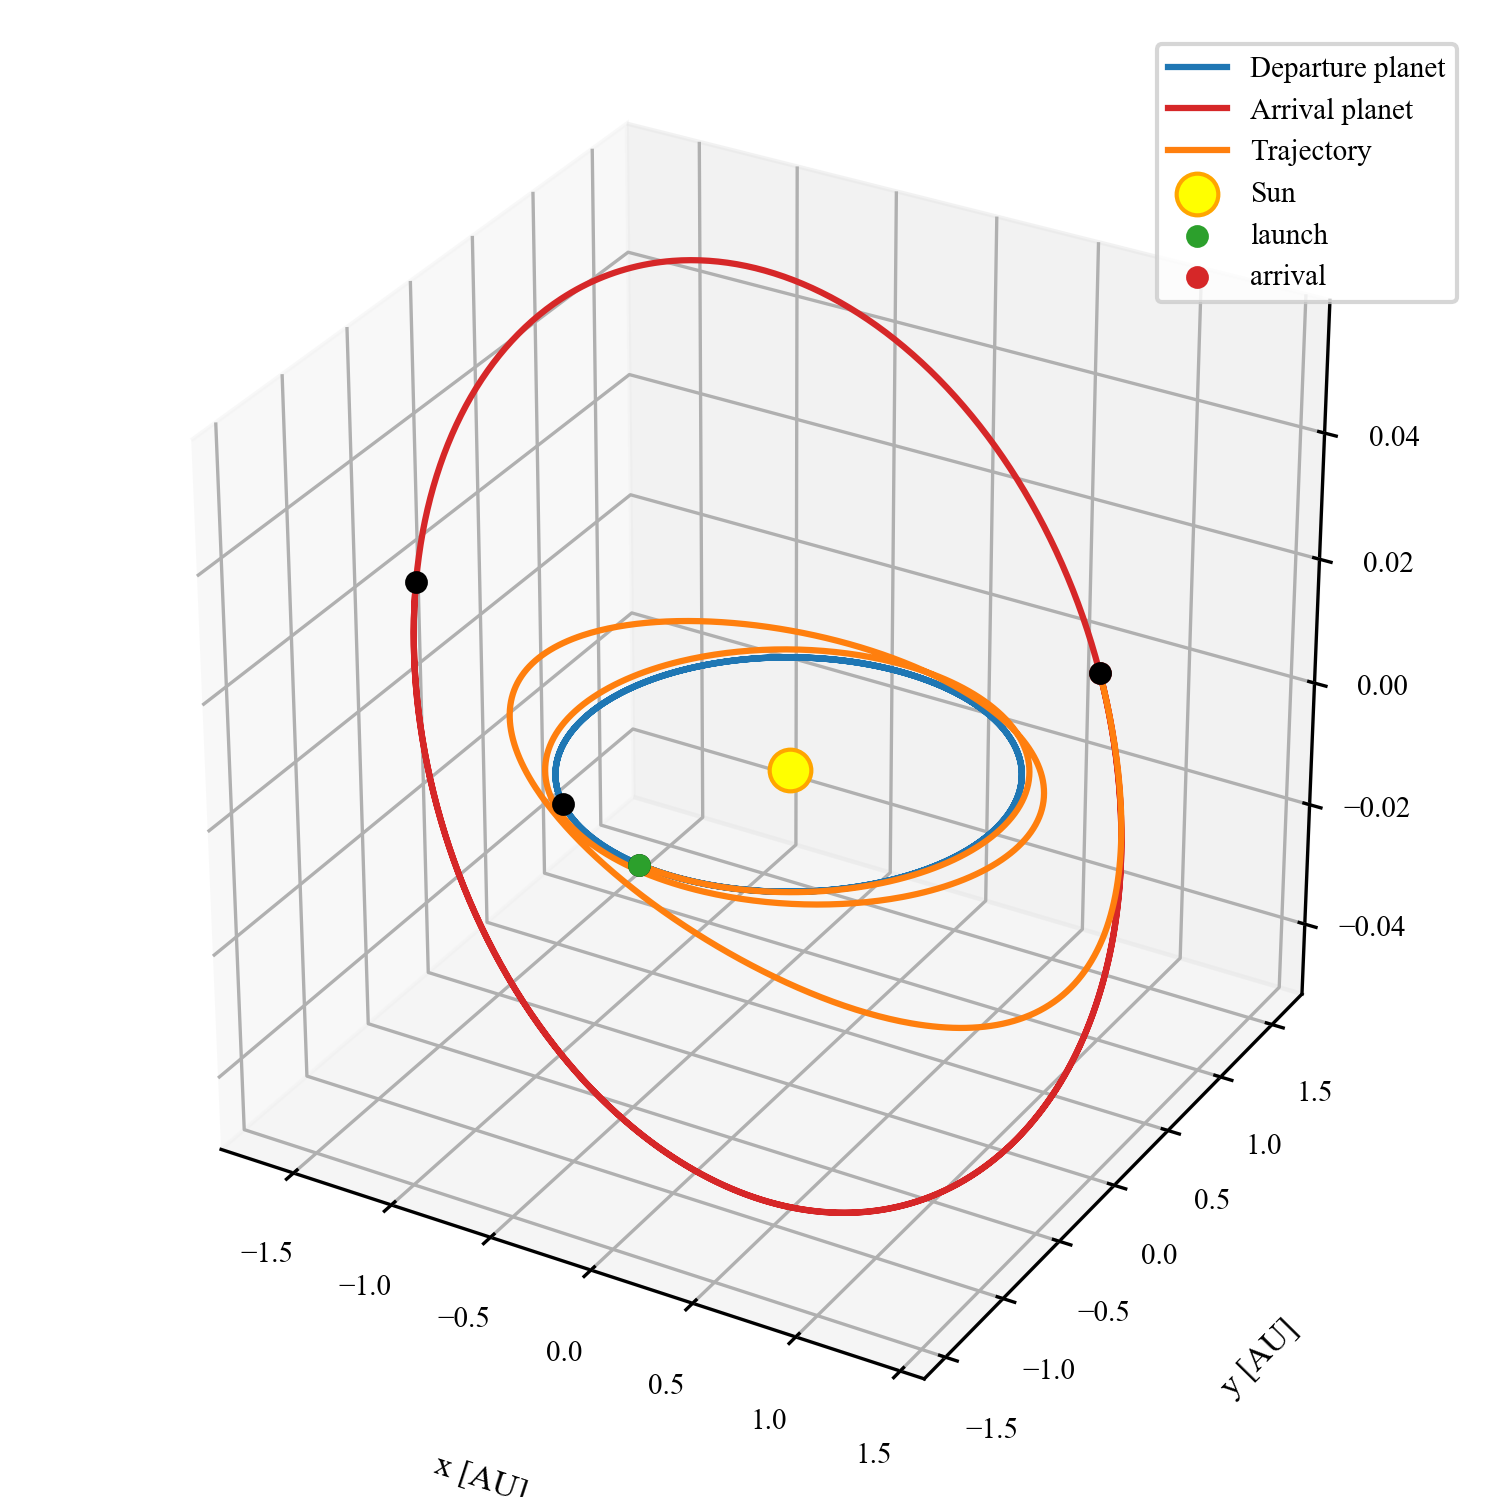

Plot hodograph


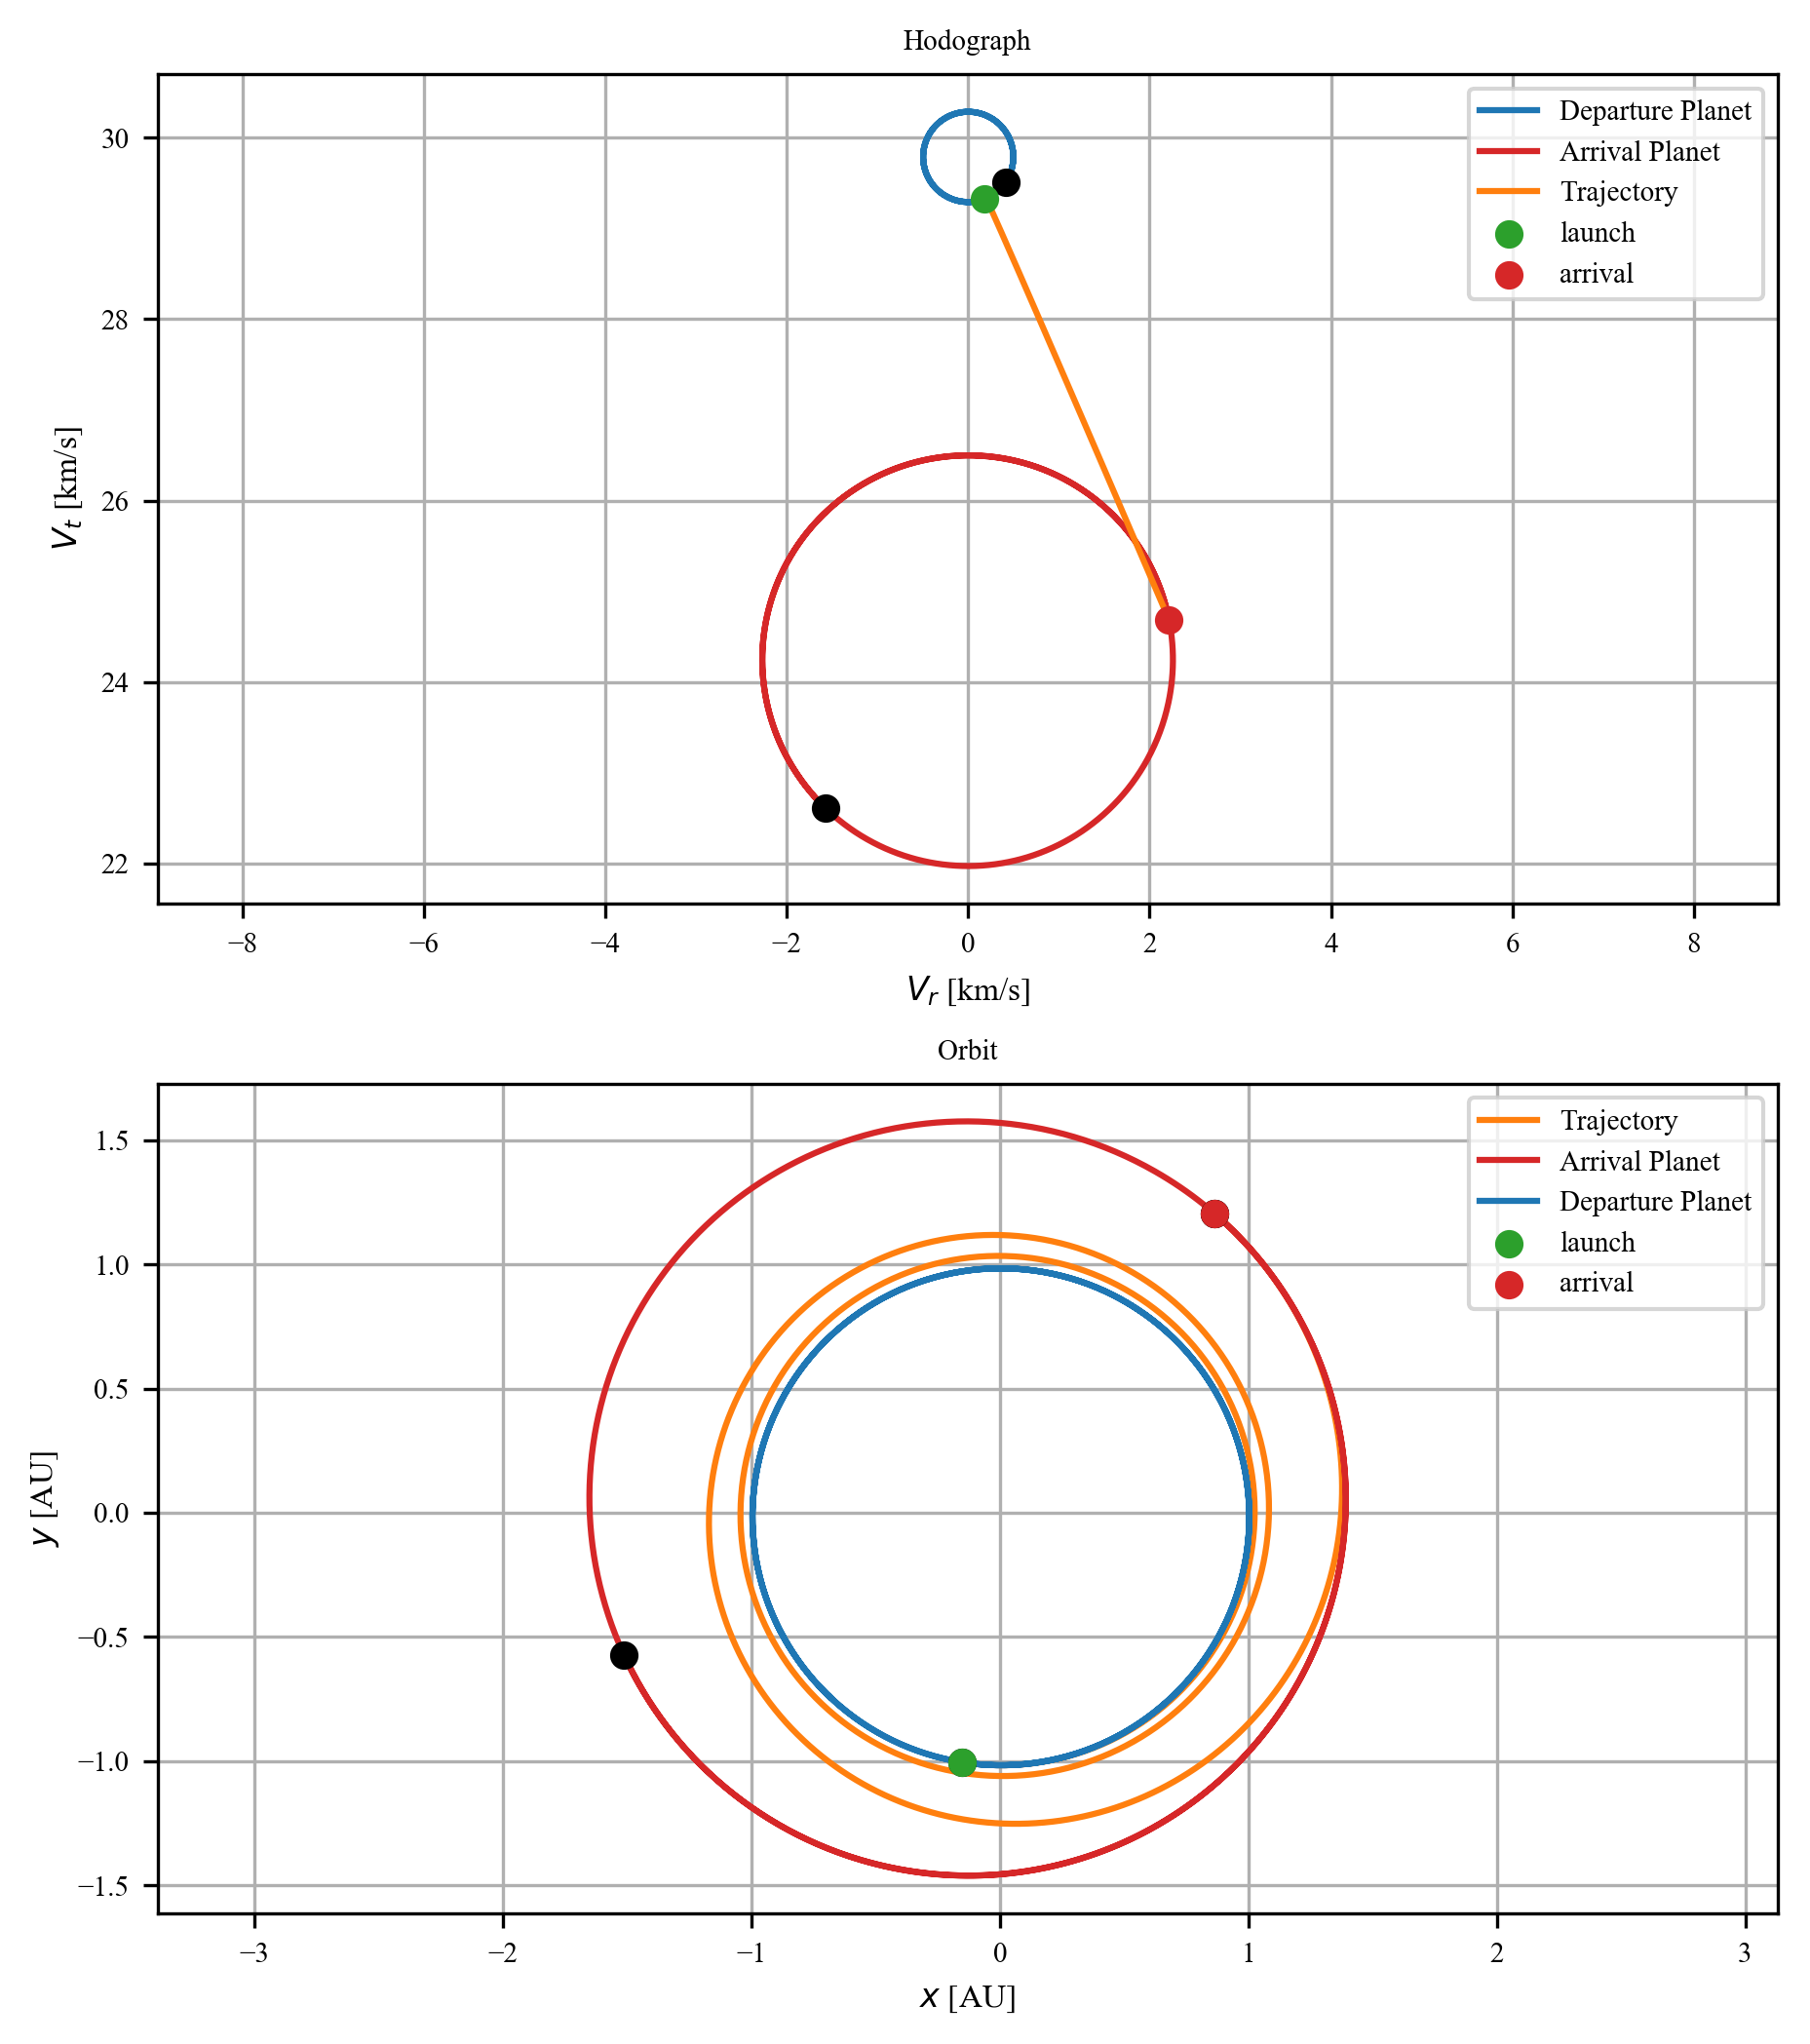

Plot thrust


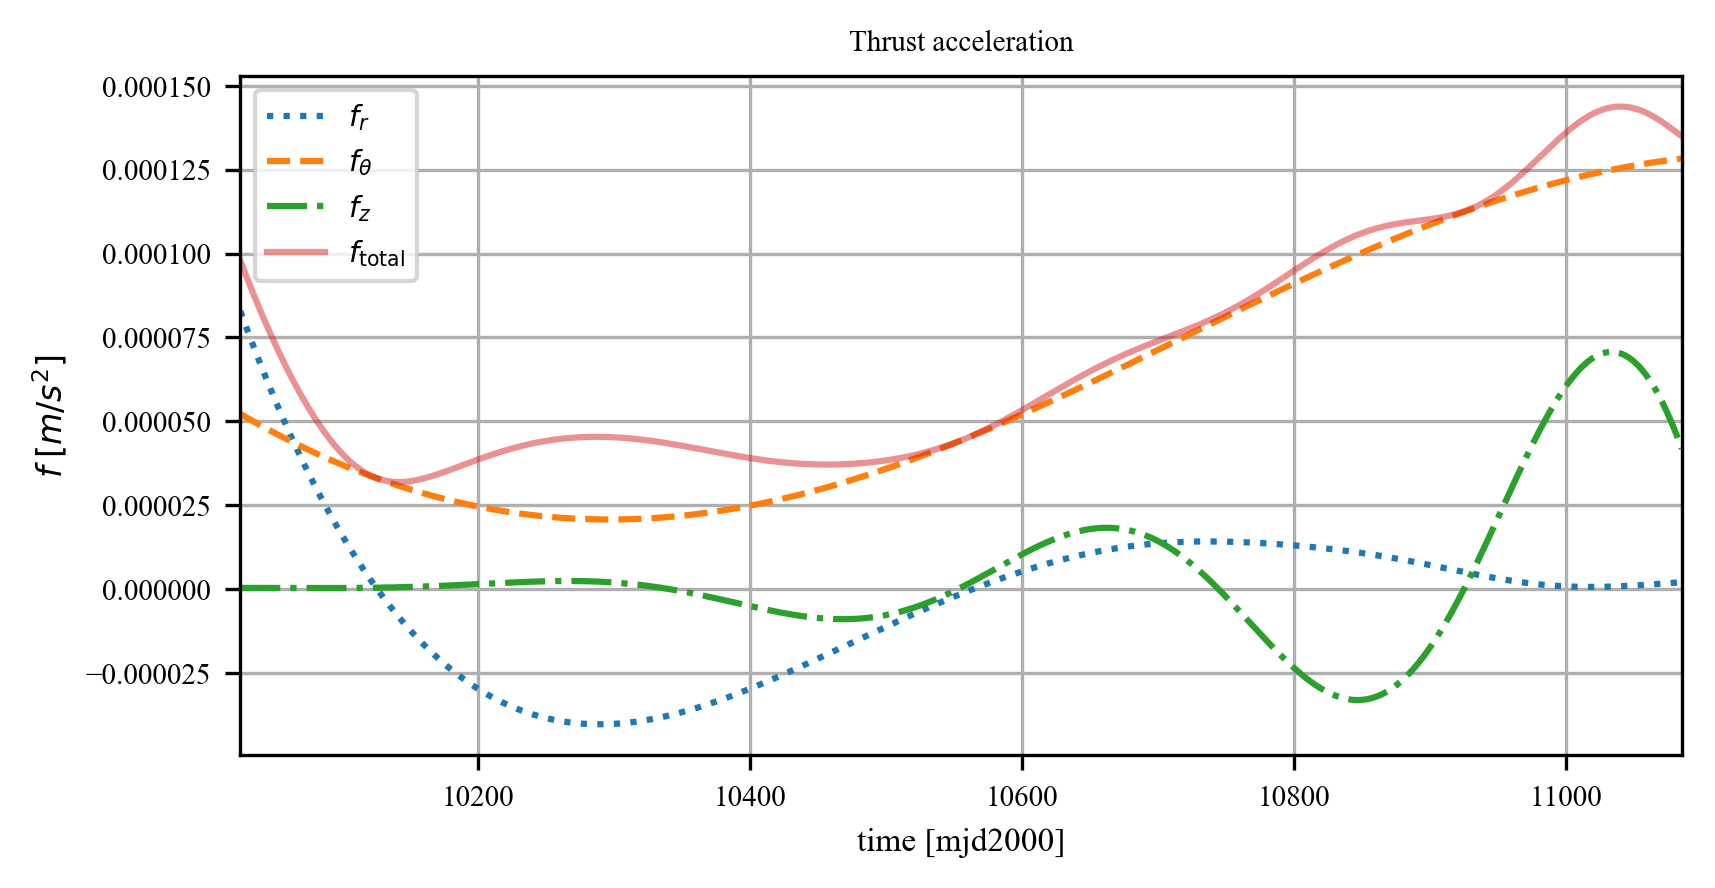

In [7]:
# retrieve and recompute best trajectory
print('\nAnalyse the best trajectory')
minDeltaV = np.min(results['deltaVs'])
tofi, depi, ni = np.where(results['deltaVs'] == minDeltaV)
bestDepDate = int(results['depDates'][depi])
bestN = int(results['Ns'][ni])
bestTof = int(results['tofs'][tofi])
scStateDep, __, __ = ephemeris(depBody, bestDepDate, mode='jpl')
scStateArr, __, __ = ephemeris(arrBody, bestDepDate+bestTof, mode='jpl')
transfer = hodographicShaping(scStateDep, scStateArr,
            departureDate=bestDepDate, 
            tof=bestTof, 
            N=bestN,
            departureBody = depBody,
            arrivalBody = arrBody,
            rShape =         'CPowPow2_scaled',
            thetaShape =     'CPowPow2_scaled',
            zShape =         'CosR5P3CosR5P3SinR5_scaled',
            rShapeFree =     'PSin05PCos05_scaled',
            thetaShapeFree = 'PSin05PCos05_scaled',
            zShapeFree =     'P4CosR5P4SinR5_scaled')
transfer.shapingRadial()
transfer.shapingVertical()
transfer.shapingTransverse()
transfer.assembleThrust()
transfer.checkBoundaryConditions()
transfer.evaluate(evalThrust='Grid', nEvalPoints=1000)
transfer.status(printBC=False)

# plot best trajectory
visWiz = plotting(transfer, samples=1000, save=False, folder=None)
visWiz.trajectory3D(scaling=None)
visWiz.hodograph(twoDplot=True)
visWiz.thrust()

## Evaluate an optimized launch window

Running each trajectory computation with free parameters and using an optimizer improves the results considerably. It also takes a lot longer. The step size was therefore reduced to 40 days. As this step size is fairly large, no adapted intitial guess is used and every optimization starts at 0. More information about initial guesses can be found in [1-3]. 

The progress of individual optimization runs can again be seen in the connected terminal window.  
Running the following code overwrites the previous results and takes about 4 to 5 hours. I recommend looking at the results before running the code.

[1] D. Gondelach and R. Noomen, Hodographic-shaping method for low-thrust interplanetary trajectory design, Journal of Spacecraft and Rockets, 2015  
[2] D. Gondelach, A Hodographic-Shaping Method for Low-Thrust Trajectory Design, MSc Thesis, TU Delft, 2012  
[3] L. Stubbig, Investigating the use of neural network surrogate models in the evolutionary optimization of interplanetary low-thrust trajectories, MSc Thesis, TU Delft, 2019

In [8]:
import pygmo as pg
from pygmoProblemsShaping import myProblemShapingSingle

In [ ]:
# initialize arrays and counters
stepSize = 40
Ns = np.arange(Nmin, Nmax+1)
depDates = np.arange(depDateMin, depDateMax, stepSize)
tofs = np.arange(tofMin, tofMax, stepSize)
deltaVs = np.zeros((len(tofs), len(depDates), len(Ns)))
numberOfTrajectories = np.prod(np.shape(deltaVs))
print('Grid search using the Hodographic shaping method with 6 DoF')
print('Computing', numberOfTrajectories, 'trajectories')
nIndex = 0
tofIndex = 0
depIndex = 0
trajectoryCounter = 1

# optimization settings
nl = pg.nlopt('neldermead')
nl.maxeval = 2500
nl.xtol_abs = 1
algo = pg.algorithm(nl)
algo.set_verbosity(100)
startTotal = time.process_time()

# initializations
freeCs = np.zeros((len(tofs), len(depDates), len(Ns), 6))

for i in Ns:
    for j in depDates:
        for k in tofs:
            # counter
            print(str(trajectoryCounter)+'/'+str(numberOfTrajectories)+'\t'+\
                str(int(np.floor(trajectoryCounter/numberOfTrajectories*100)))+\
                '%', end='\r')
            
            # create problem instance
            scStateDep, __, __ = ephemeris(depBody, j, mode='jpl')
            scStateArr, __, __ = ephemeris(arrBody, j+k, mode='jpl')
            prob = pg.problem(myProblemShapingSingle(
                scStateDep, scStateArr,
                depDate=j, tof=k, N=i))
            pop = pg.population(prob, 1)
            
            # intial guess
            pop.set_x(0, [0, 0, 0, 0, 0, 0])
            initialGuess = pop.get_x()[pop.best_idx()]
            
            # run optimization
            start = time.process_time()
            pop = algo.evolve(pop)
            end = time.process_time()
            compTime = (end-start)
            
            # retrieve results
            bestTrajectory = pop.get_x()[pop.best_idx()]
            bestDeltaV = pop.get_f()[pop.best_idx()]
            nFeval = pop.problem.get_fevals()
            deltaVs[tofIndex, depIndex, nIndex] = bestDeltaV
            freeCs[tofIndex, depIndex, nIndex, :] = bestTrajectory
            tofIndex += 1
            trajectoryCounter += 1
            
        depIndex += 1  # could be done with enumerate() in the for loop
        tofIndex = 0
    nIndex += 1
    depIndex = 0

# print elapsed time
endTotal = time.process_time()
print('Finished computation in ',\
      round((endTotal - startTotal)/60, 2), ' min')
print('Computation time per trajectory was ',
      round((endTotal - startTotal)/numberOfTrajectories, 2), ' s')

# combine results in a single dictionary
results = {}
results['deltaVs'] = deltaVs
results['depDates'] = depDates
results['Ns'] = Ns
results['tofs'] = tofs
results['freeCs'] = freeCs

Grid search using the Hodographic shaping method with 6 DoF
Computing 16872 trajectories


Plotting best imshow


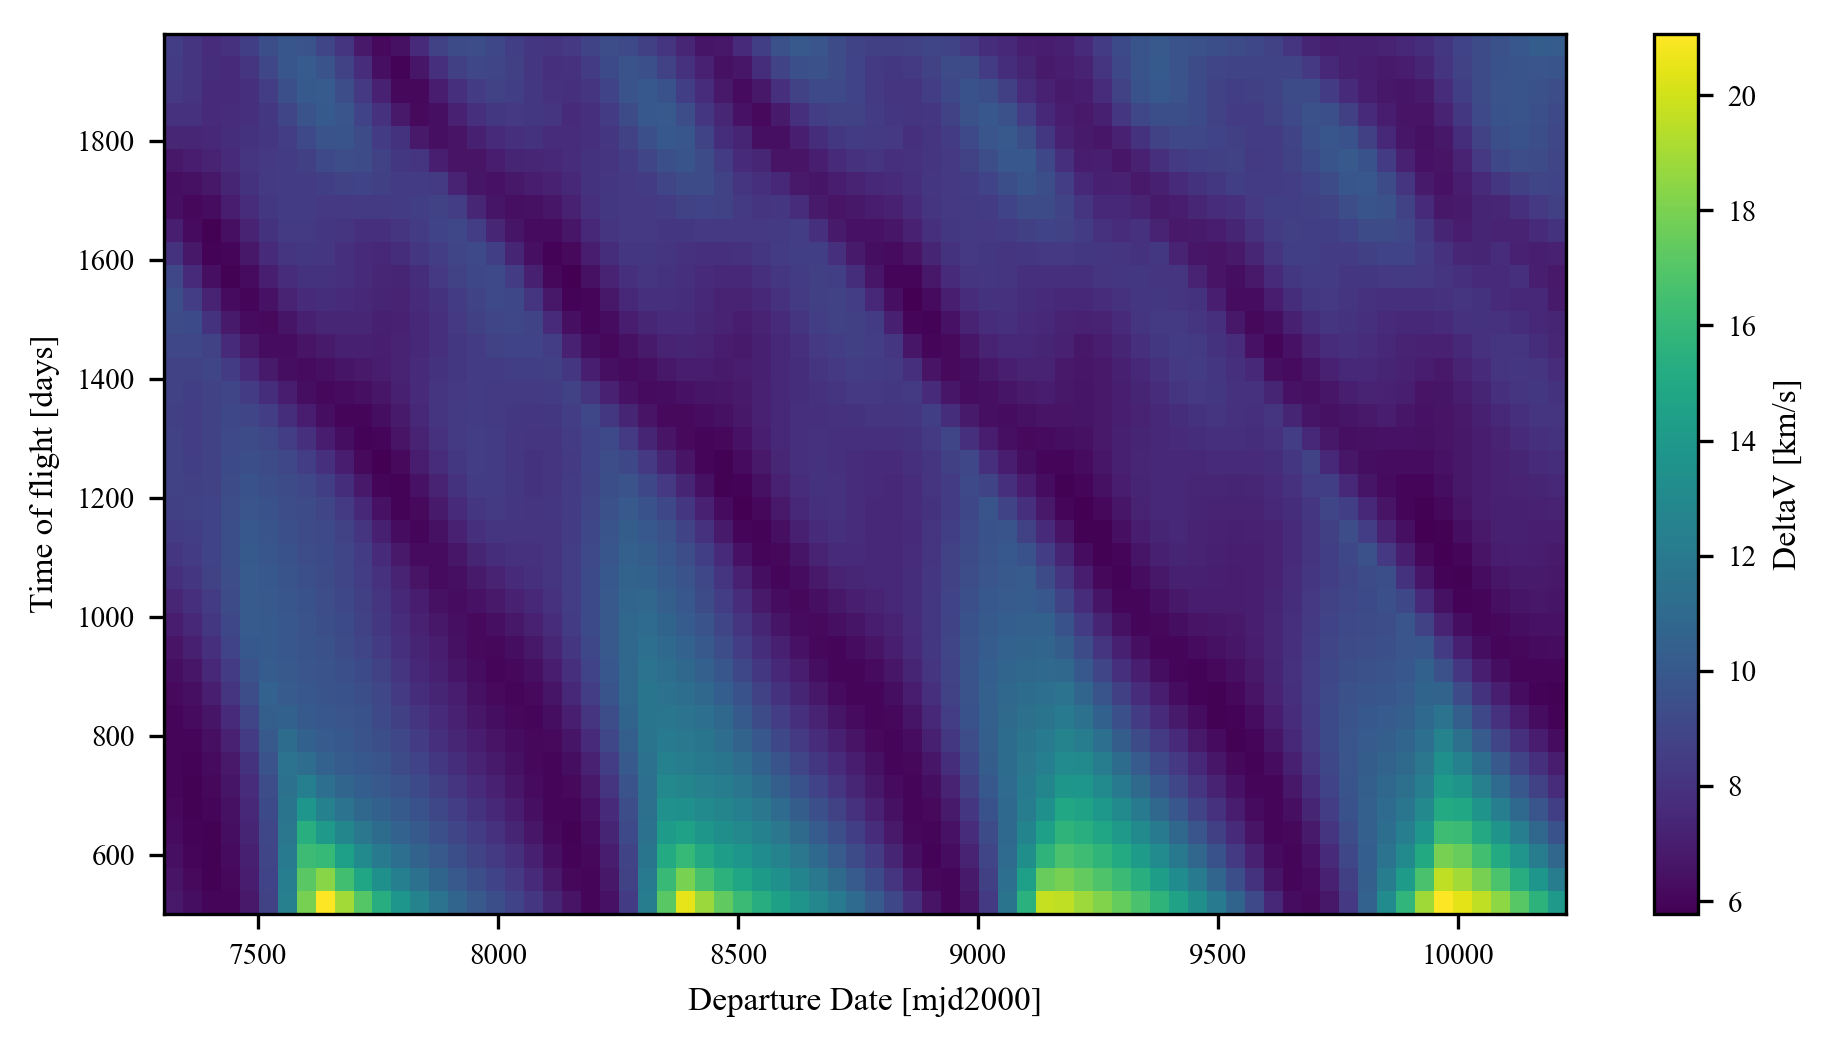

Plotting best Ns


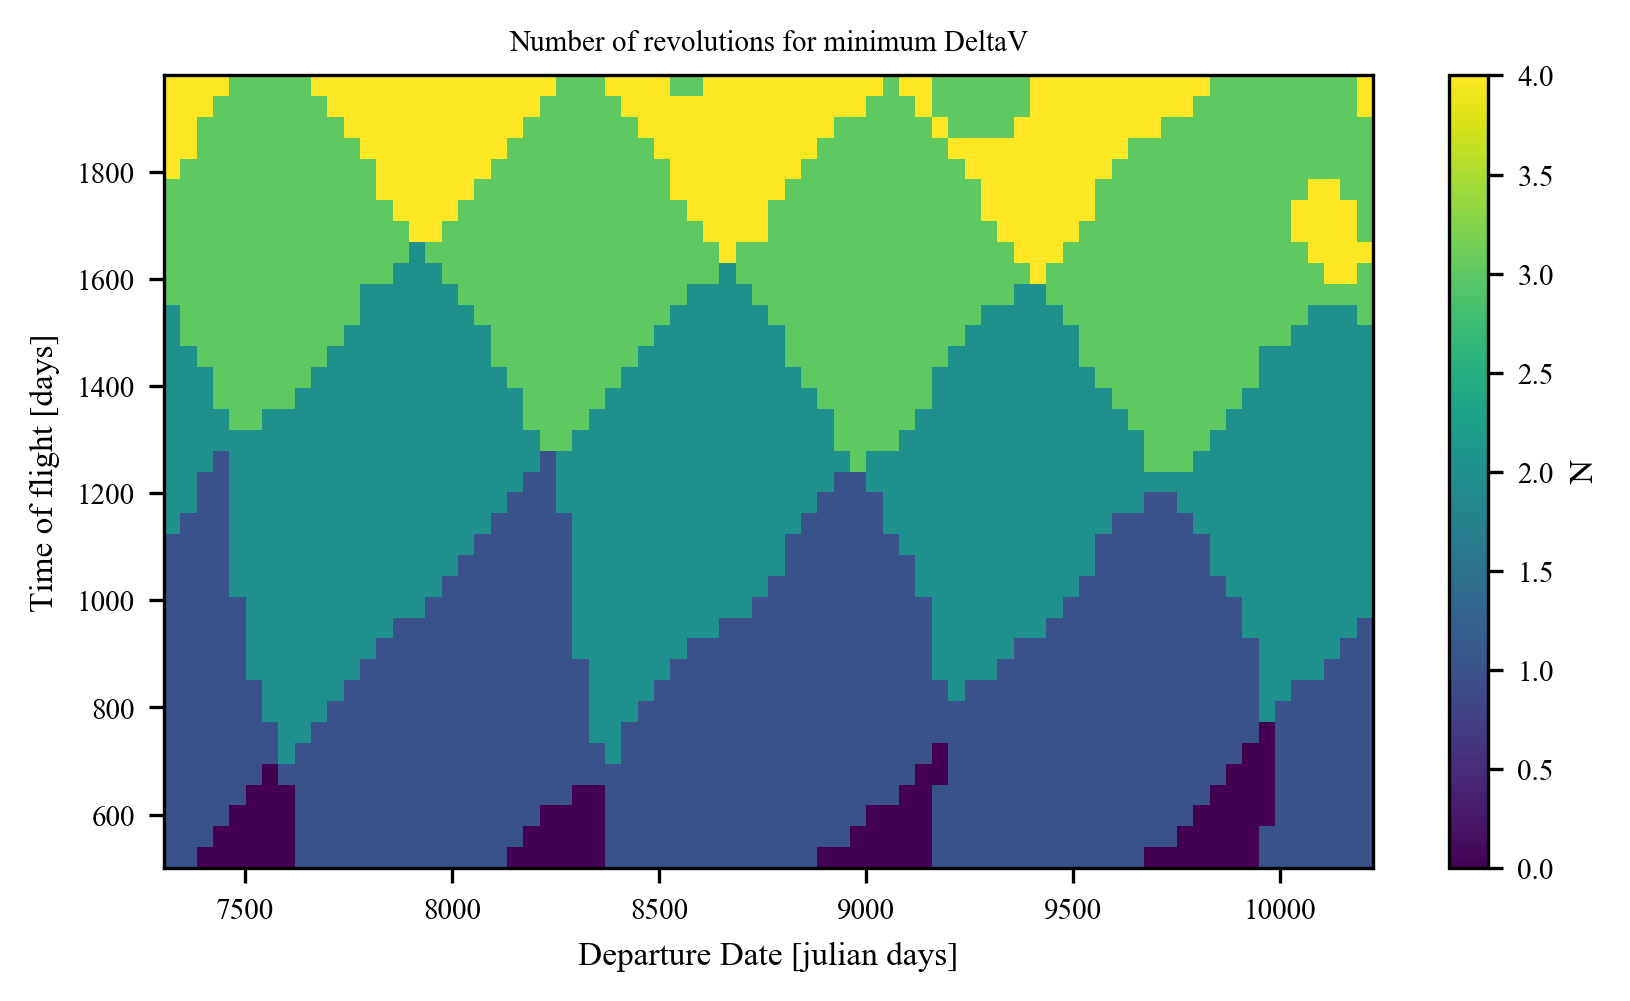

Plotting contour (imshow)


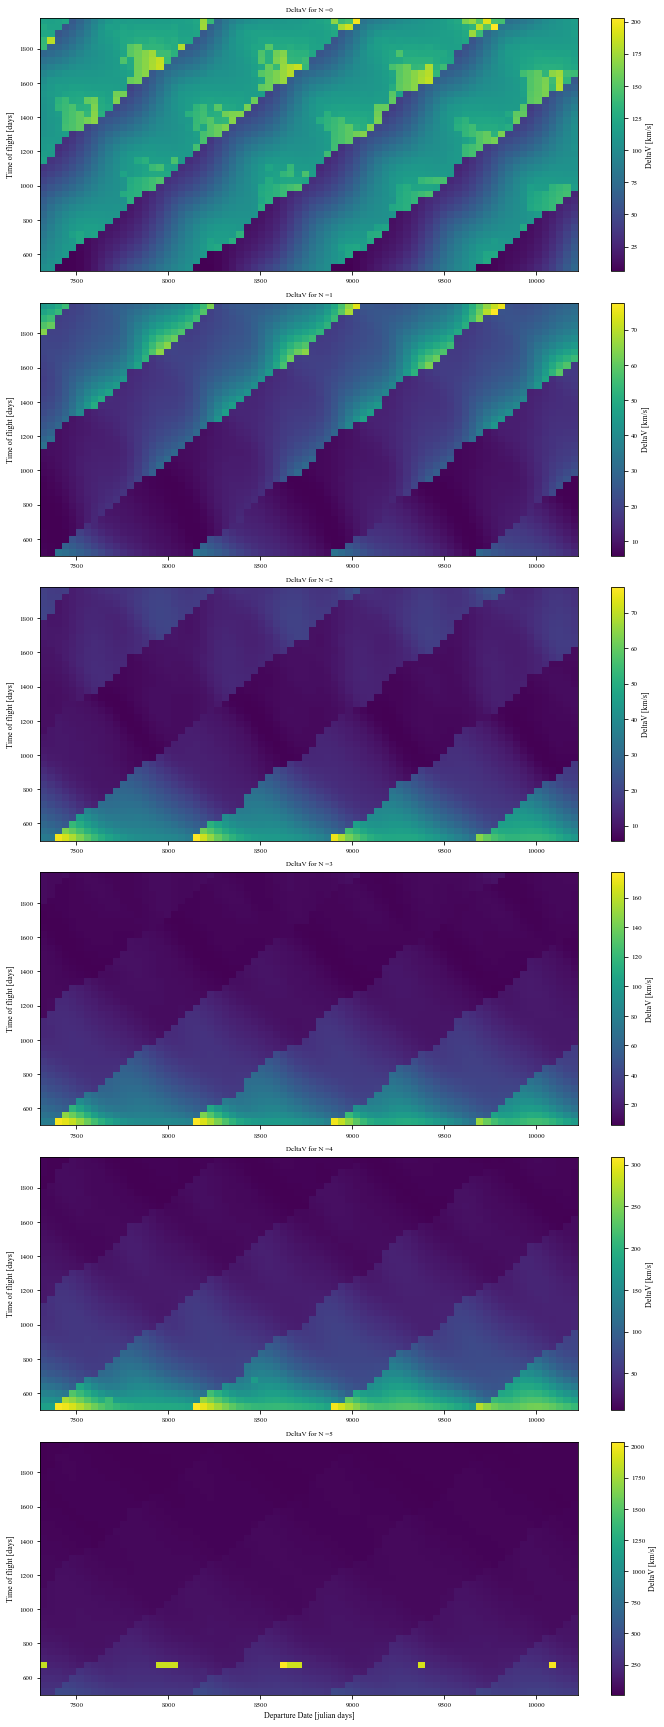

In [12]:
gridSearchVis = plottingGridSearch(results, save=False, folder=None)

# The best trajectory found for each point in the launch window
gridSearchVis.resultImshowBest()

# the corresponding number of revolutions
gridSearchVis.resultBestN()

# the overview for each N
gridSearchVis.resultContoursImshow()

The best trajectory is again retrieved and plotted, just as for the lowest-order search above.


Analyse the best trajectory
###############################################################
Hodographic Shaping Problem: earth to mars

Settings
Departure state:  [ 1.51e+11 -2.39e+00  6.37e+06  4.31e+02  2.95e+04  1.36e+00]
Arrival state:	  [2.22e+11 9.50e-01 6.15e+08 2.21e+03 2.47e+04 7.99e+02]
Departure date:	 2027-May-04 00:00:00
Departure date:	 9985 mjd2000
Arrival date:	 2030-May-08 00:00:00
Time of Flight:	 1100  days
Revolutions:	 2
Transfer angle:  191.46  deg
Radial velocity:	 CPowPow2_scaled
Traverse velocity:	 CPowPow2_scaled
Axial velocity:		 CosR5P3CosR5P3SinR5_scaled

Free part of shape (input)
Radial velocity free:	PSin05PCos05_scaled
Traverse velocity free:	PSin05PCos05_scaled
Axial velocity free:	P4CosR5P4SinR5_scaled
Radial coefficients free:	 [0 0]
Transverse coefficients free:	 [0 0]
Vertical coefficients free:	 [0 0]

Velocity functions
Radial coefficients:		 [  431.14 -1675.99  3458.91]
Transverse coefficients:	 [29540.65  2664.23 -7520.15]
Vertical coefficient

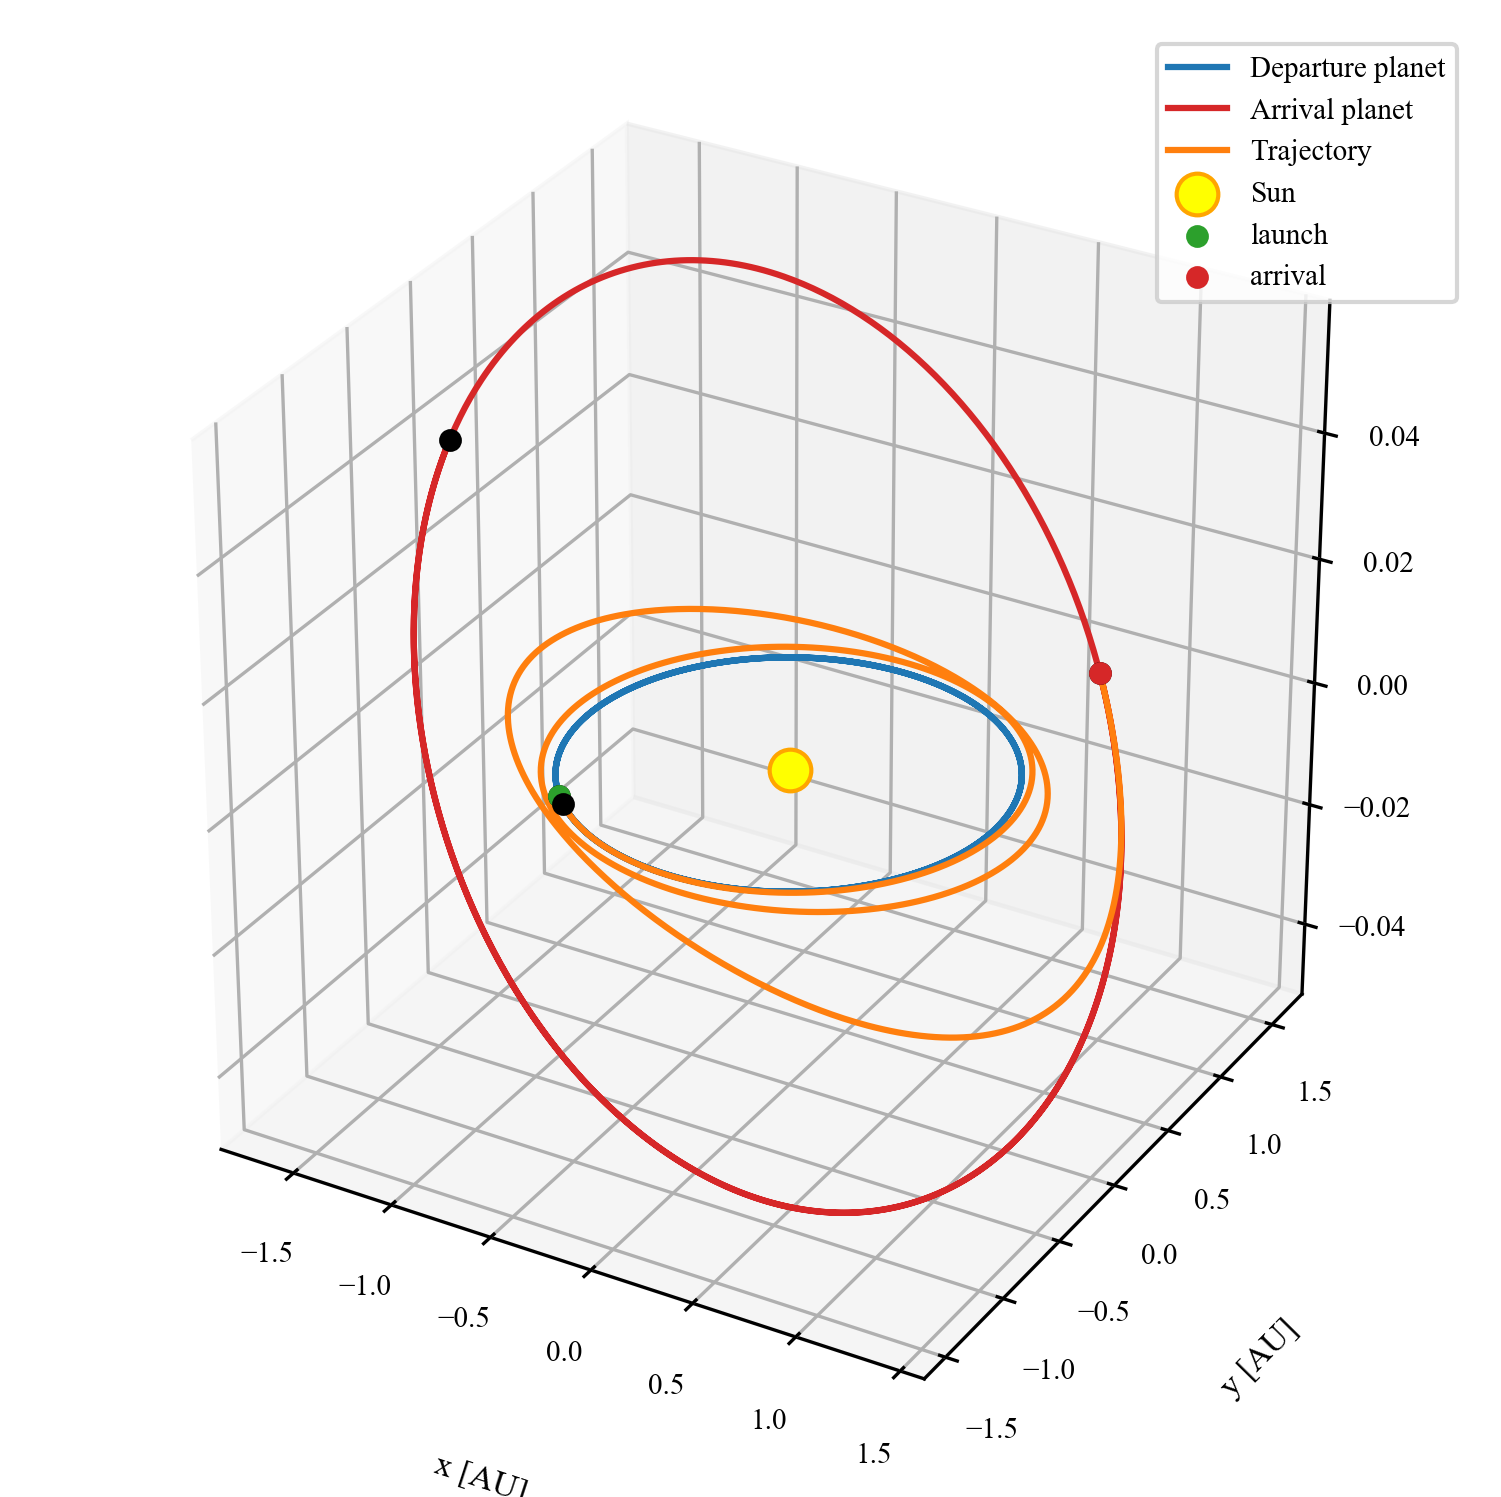

Plot hodograph


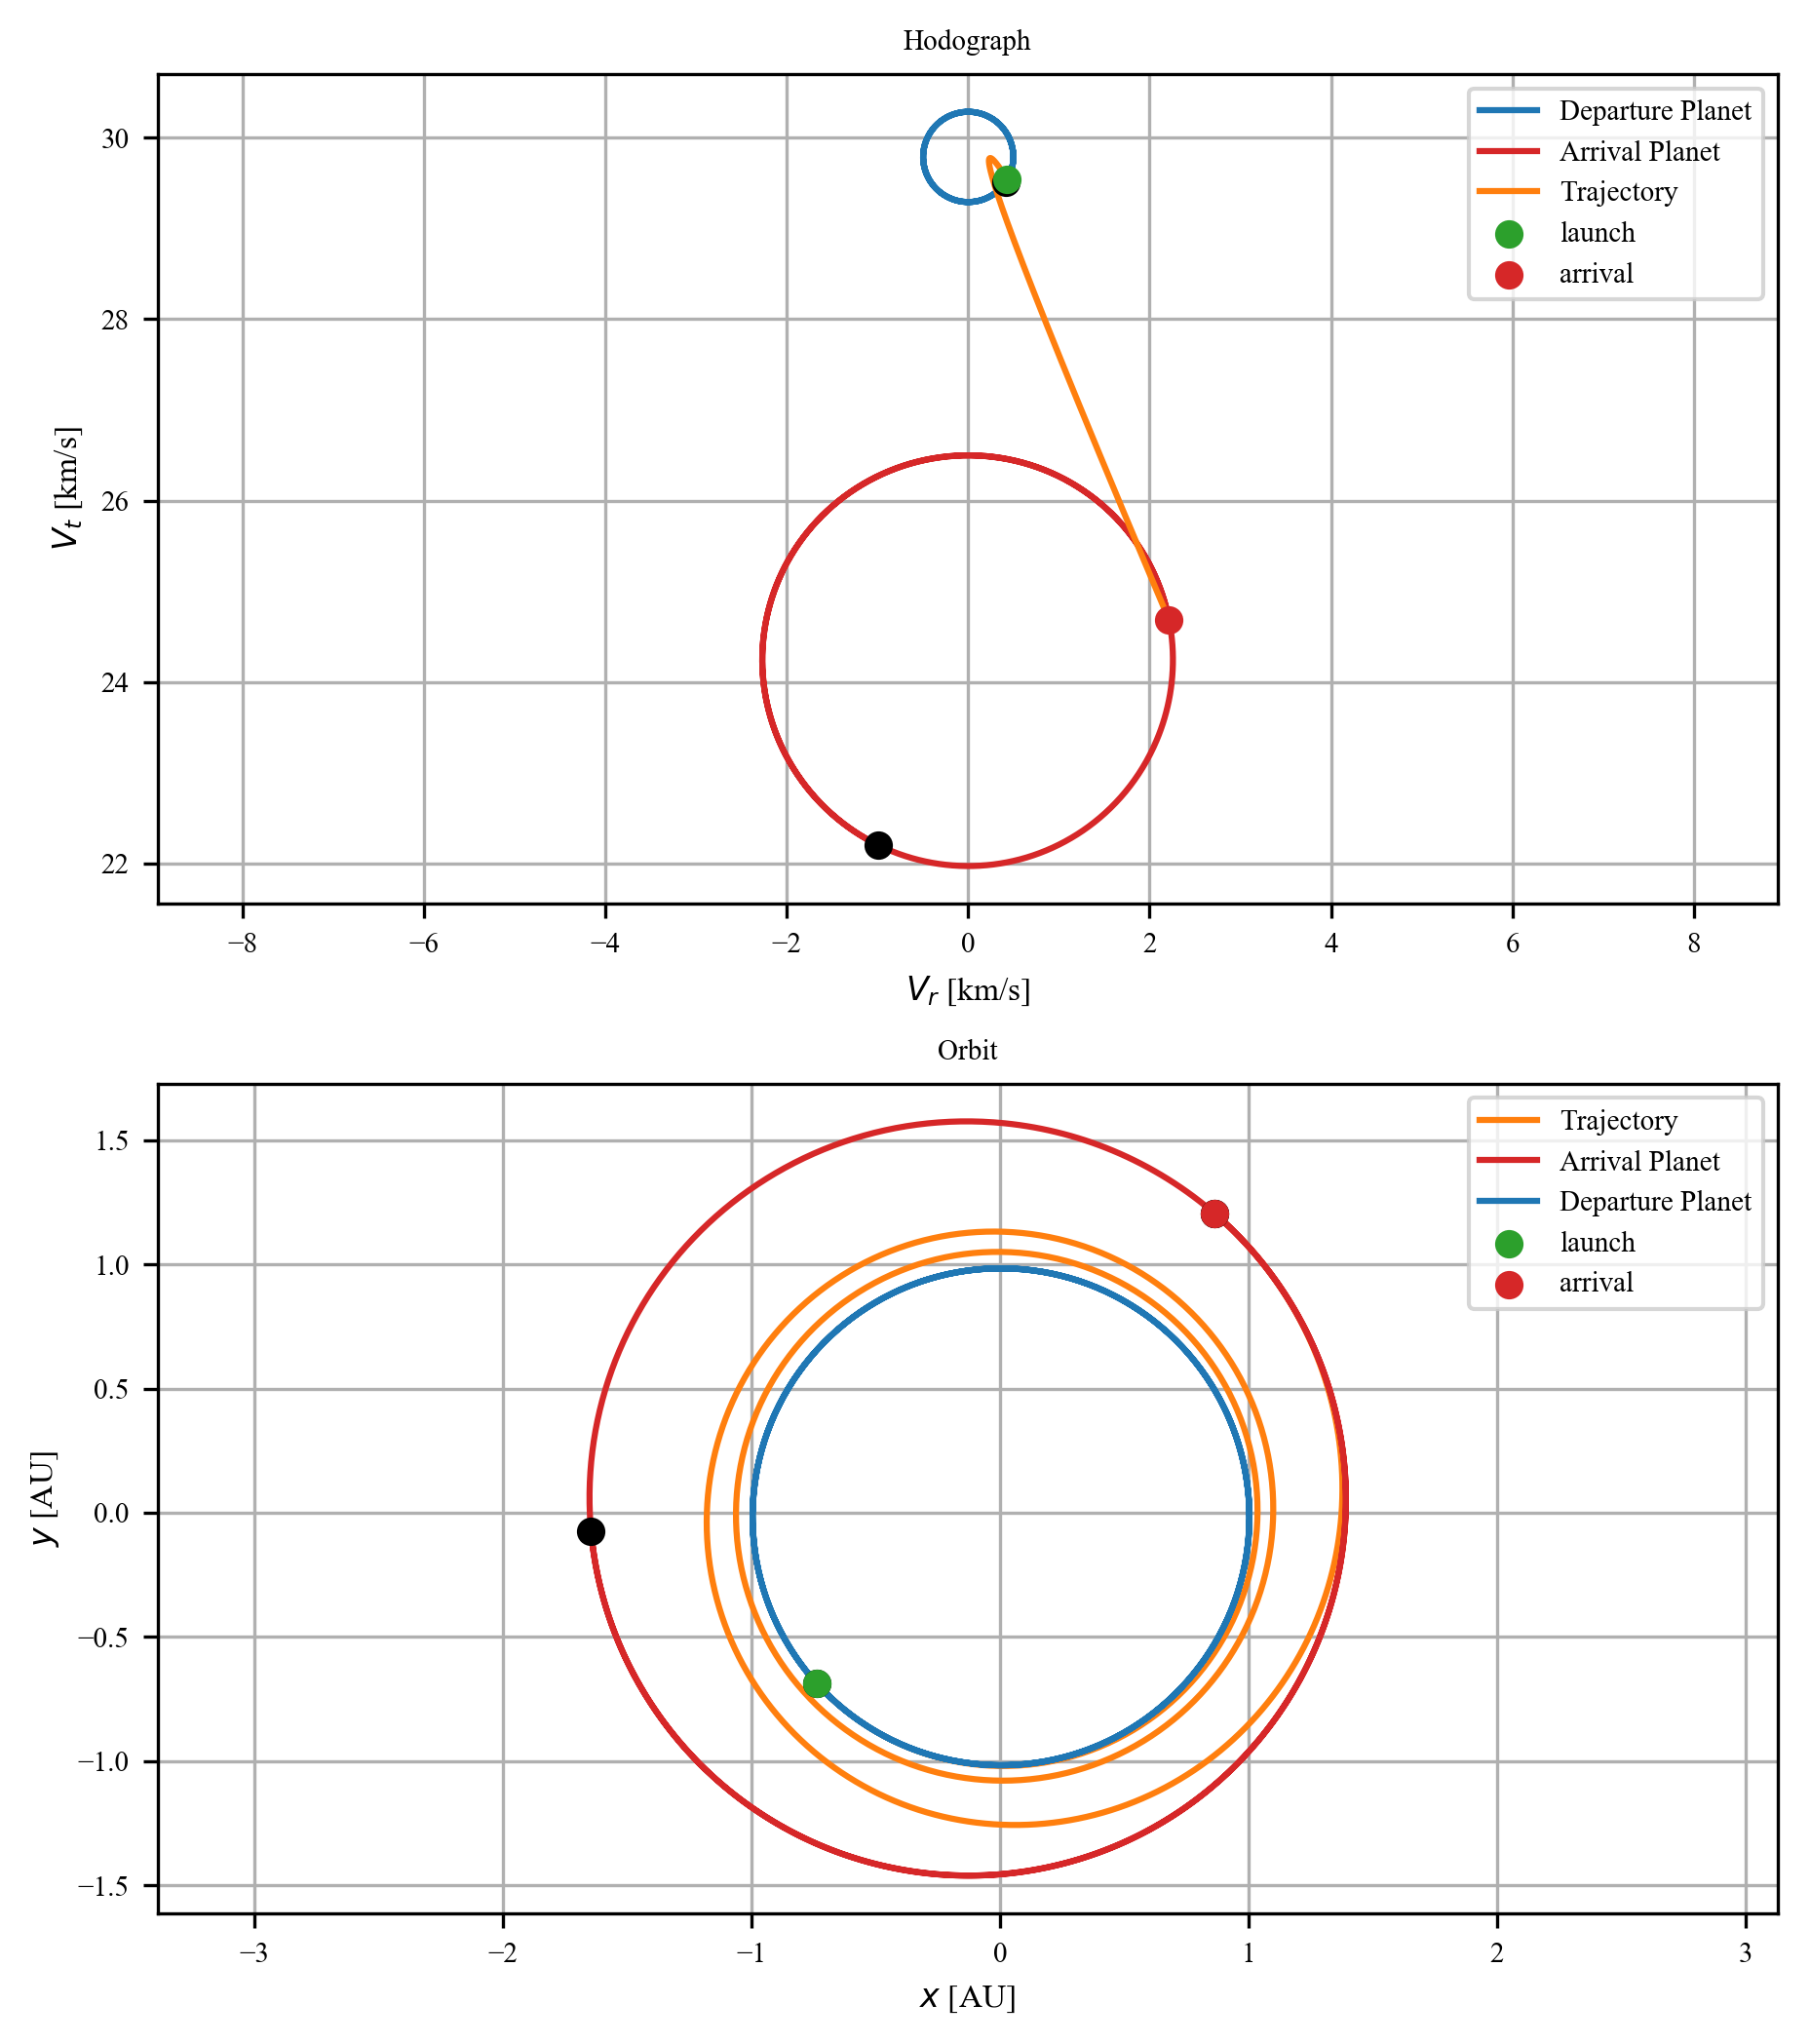

Plot thrust


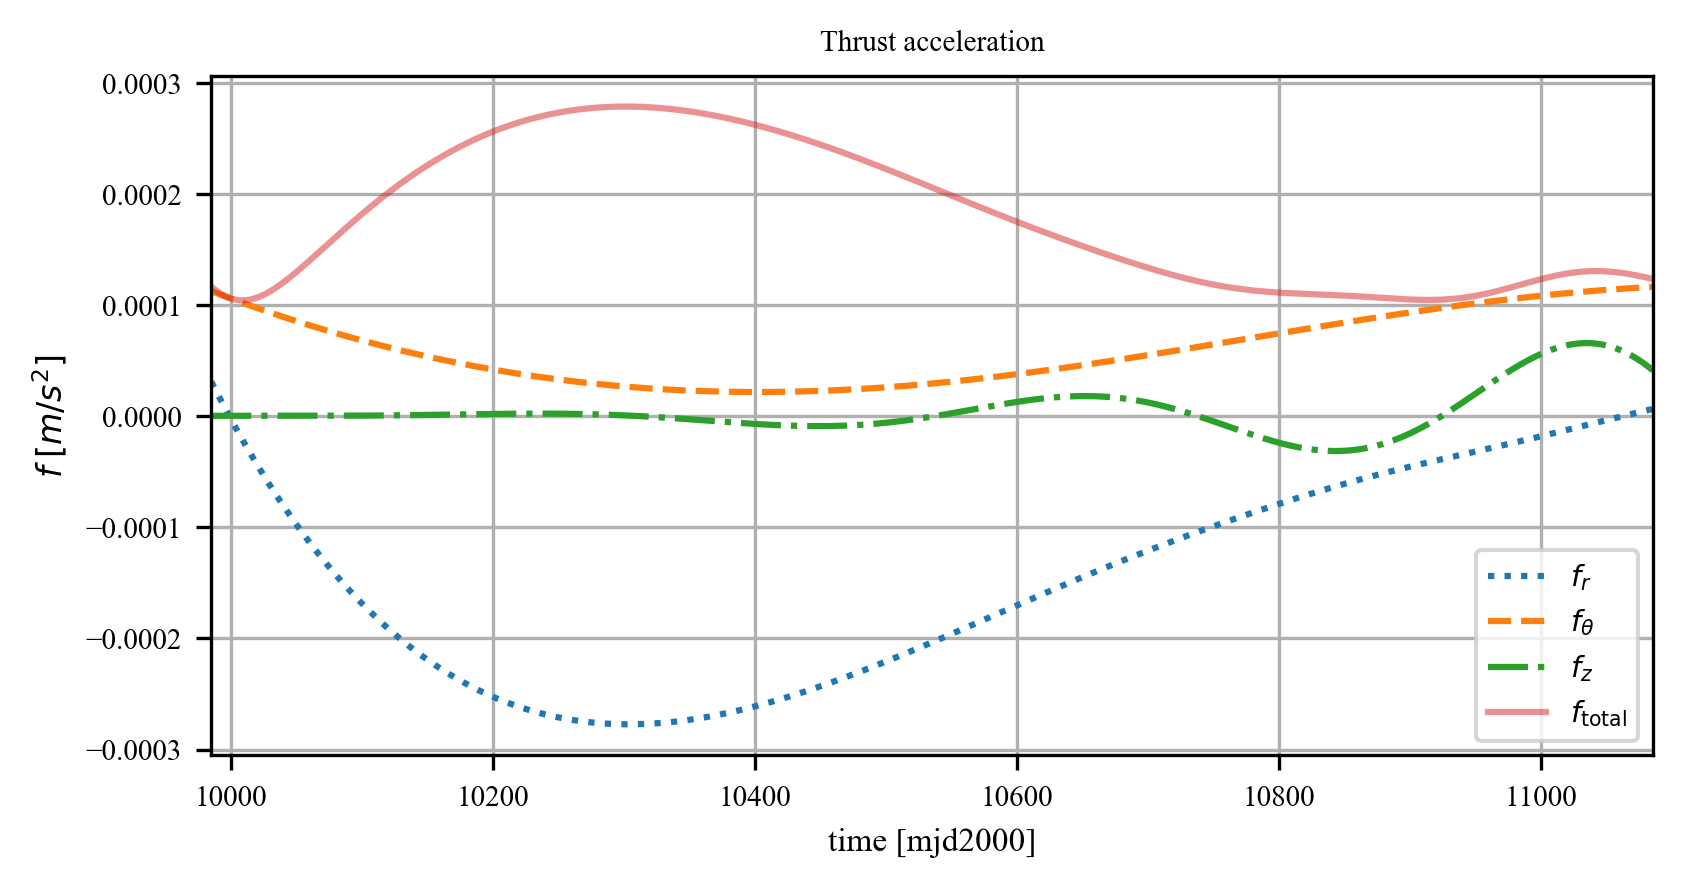

In [11]:
# retrieve and recompute best trajectory
print('\nAnalyse the best trajectory')
minDeltaV = np.min(results['deltaVs'])
tofi, depi, ni = np.where(results['deltaVs'] == minDeltaV)
bestDepDate = int(results['depDates'][depi])
bestN = int(results['Ns'][ni])
bestTof = int(results['tofs'][tofi])
scStateDep, __, __ = ephemeris(depBody, bestDepDate, mode='jpl')
scStateArr, __, __ = ephemeris(arrBody, bestDepDate+bestTof, mode='jpl')
transfer = hodographicShaping(scStateDep, scStateArr,
            departureDate=bestDepDate, 
            tof=bestTof, 
            N=bestN,
            departureBody = depBody,
            arrivalBody = arrBody,
            rShape =         'CPowPow2_scaled',
            thetaShape =     'CPowPow2_scaled',
            zShape =         'CosR5P3CosR5P3SinR5_scaled',
            rShapeFree =     'PSin05PCos05_scaled',
            thetaShapeFree = 'PSin05PCos05_scaled',
            zShapeFree =     'P4CosR5P4SinR5_scaled')
transfer.shapingRadial()
transfer.shapingVertical()
transfer.shapingTransverse()
transfer.assembleThrust()
transfer.checkBoundaryConditions()
transfer.evaluate(evalThrust='Grid', nEvalPoints=1000)
transfer.status(printBC=False)

# plot best trajectory
vizzz = plotting(transfer, samples=1000, save=False, folder=None)
vizzz.trajectory3D(scaling=None)
vizzz.hodograph(twoDplot=True)
vizzz.thrust()